## Objective
Train one model to make sure process of creating and training model works well

In [2]:
%load_ext autoreload

In [3]:
SAMP_FREQ = 30
SAMPLE_SIZE = 10 * SAMP_FREQ
FRONT_BUFFER = END_BUFFER = 2 * SAMP_FREQ
ISI_WF_MIN = round(0.2*SAMP_FREQ)
NUM_WFS_PROBS = [0.5, 0.3, 0.12, 0.06, 0.02]  # Not all dataloaders use this

## Load Data
Needed for "Create and Train Model", "Cross validation models", "Tune loc prob thresh of model"

NOT needed for "Test performance of models"

In [2]:
# import numpy as np
# nonzero_probs = np.array([[0.8044444444444444, 0.17333333333333334, 0.017777777777777778, 0.0022222222222222222, 0.0022222222222222222]])
# num_wfs_probs = [1 - np.sum(nonzero_probs)/2]
# num_wfs_probs.extend(*nonzero_probs/2)
# print(num_wfs_probs)

# NUM_WFS_PROBS = [0.8165, 0.1529, 0.0259, 0.004, 0.0006, 0.0001]  # Original neuropixels, ith element is for i+1 wfs

In [ ]:
%autoreload 2
import torch
from src import data, meta

cross_val = data.RecordingCrossVal(
    samples_per_waveform=(1, 1), front_buffer=FRONT_BUFFER, end_buffer=END_BUFFER,
    num_wfs_probs=NUM_WFS_PROBS, 
    isi_wf_min=ISI_WF_MIN, isi_wf_max=None,
    rec_paths=meta.SI_MOUSE[:], thresh_amp=36, 
    thresh_std=0.6,
    sample_size=SAMPLE_SIZE, start=0, ms_before=3, ms_after=3, gain_to_uv=meta.GAIN_TO_UV,
    device="cuda", dtype=torch.float16, mmap_mode="r",
    as_datasets=False,
    num_workers=0, shuffle=True, batch_size=1
)

In [4]:
# Get fold  
rec, train, val = cross_val[2]
cross_val.summarize(rec, train, val)

Val Recording: probe_773592320 - Train: 4597 samples - Val: 1655 - Train/Val: 36.0%
Train num wfs probs:
0: 50.0%, 1: 30.0%, 2: 12.0%, 3: 6.0%, 4: 2.0%, 
Val num wfs probs:
0: 50.0%, 1: 30.0%, 2: 12.0%, 3: 6.0%, 4: 2.0%, 

### Find number of waveforms in each recording

In [4]:
from src.data import MultiRecordingDataset
from src import meta

import numpy as np
import torch

num_wfs = []
for rec_path in meta.SI_MOUSE[:]:
    dataset = MultiRecordingDataset.load_single(path_folder=rec_path,
                                            samples_per_waveform=1, front_buffer=FRONT_BUFFER, end_buffer=END_BUFFER,
                                            num_wfs_probs=NUM_WFS_PROBS, isi_wf_min=ISI_WF_MIN, isi_wf_max=None,
                                            sample_size=SAMPLE_SIZE,
                                            device="cuda", dtype=torch.float16, gain_to_uv=meta.GAIN_TO_UV,
                                            thresh_amp=3*meta.GAIN_TO_UV, thresh_std=0.6)
    print(f"{rec_path.name}: {len(dataset)}")
    num_wfs.append(len(dataset))
num_wfs = np.array(num_wfs, dtype="float64")

probe_773592315: 1054
probe_773592318: 1278
probe_773592320: 1973
probe_773592324: 934
probe_773592328: 1833
probe_773592330: 892


In [5]:
print(f"Mean: {np.mean(num_wfs):.2f}")
print(f"STD: {np.std(num_wfs):.2f}")

Mean: 1327.33
STD: 427.00


## Create and Train Model

In [5]:
import time
%autoreload 2
from src.model import ModelSpikeSorter
from src.utils import random_seed

random_seed(2)

model = ModelSpikeSorter(
    num_channels_in=1, 
    sample_size=SAMPLE_SIZE, buffer_front_sample=FRONT_BUFFER, buffer_end_sample=END_BUFFER,
    loc_prob_thresh=35, buffer_front_loc=0, buffer_end_loc=0,
    input_scale=0.01,
    device="cuda", dtype=torch.float16,
    architecture_params=(
        -4, 50, "relu", 0, 0, 0, 0
    )
)
model.init_weights_and_biases("xavier", prelu_init=0)
model.model.init_final_bias(model.num_output_locs, val.num_wfs_probs)

model.fit(train, val, 
            num_epochs=200, epoch_patience=10, epoch_thresh=0.01,            
            lr=2e-4, # Retraining neuropixels right before Koch's visit
            
            # original MEA?
            # lr=7.76e-4, 
            momentum=0.85, 
            optim="momentum",
            
            lr_patience=5, lr_factor=0.4,
            tune_thresh_every=10, save_best=True)

Using random seed 2
Train: 4376 samples
Valid: 1438 samples
Num wfs probs: [0.5, 0.3, 0.12, 0.06, 0.02]

Before Training
Train: Loss: 5.099 | WF Detected: 0.0% | Accuracy: 99.6% | Recall: 0.0% | Precision: nan% | F1 Score: nan% | Loc MAD: nan frames = nan ms
Valid: Loss: 5.036 | WF Detected: 0.0% | Accuracy: 99.6% | Recall: 0.0% | Precision: nan% | F1 Score: nan% | Loc MAD: nan frames = nan ms

Epoch: 1/200
Train: Loss: 1.555 | WF Detected: 86.8% | Accuracy: 99.9% | Recall: 79.2% | Precision: 91.3% | F1 Score: 84.8% | Loc MAD: 0.27 frames = 0.0089 ms
Valid: Loss: 1.294 | WF Detected: 85.8% | Accuracy: 99.9% | Recall: 84.3% | Precision: 98.2% | F1 Score: 90.7% | Loc MAD: 0.25 frames = 0.0083 ms
Time: 37.65s

Epoch: 2/200
Train: Loss: 1.363 | WF Detected: 96.8% | Accuracy: 99.9% | Recall: 85.3% | Precision: 88.2% | F1 Score: 86.7% | Loc MAD: 0.26 frames = 0.0088 ms
Valid: Loss: 1.138 | WF Detected: 92.5% | Accuracy: 99.9% | Recall: 90.3% | Precision: 97.6% | F1 Score: 93.9% | Loc MAD: 0.

([(5.098572581734039, 0.0, 99.55768840138127, 0.0, nan, nan, nan, nan),
  (1.5550950814644642,
   86.76764789939983,
   99.87393357708714,
   79.19405544441268,
   91.27140974967062,
   84.80489671002294,
   0.26849512811259474,
   0.008949837603753157),
  (1.3631554452985035,
   96.77510608203677,
   99.88294738980296,
   85.34653465346534,
   88.19058754750073,
   86.74525589419206,
   0.26450116009280744,
   0.008816705336426915),
  (1.3217397812733485,
   94.4639718804921,
   99.88866036969327,
   84.38781487990627,
   89.33333333333333,
   86.79017924386203,
   0.2738632419298855,
   0.009128774730996183),
  (1.3821987329932846,
   83.19613965370424,
   99.84790777980906,
   74.59551518592109,
   89.66223132036848,
   81.43786798884413,
   0.20357686453576865,
   0.006785895484525622),
  (1.2981415021572078,
   91.94828092859242,
   99.8938655291489,
   83.6908610049956,
   91.01949504634068,
   87.20146968769136,
   0.26615168539325845,
   0.008871722846441948),
  (1.266795730242

In [6]:
# # Save model
# from pathlib import Path
# SAVE_PATH = Path("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/240227/c")
# ##
# model_name = model.save(SAVE_PATH)

# # Copy this notebook
# from src.utils import copy_file  
# copy_file("/data/MEAprojects/DLSpikeSorter/src/train/single.ipynb", SAVE_PATH / model_name / "src")

Not copying train.py


In [7]:
model.get_loc_prob_thresh()

22.499999403953552

In [ ]:
# from model import ModelSpikeSorter
# model = ModelSpikeSorter.load("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/230703/c")

# Plot performance
from utils import random_seed
random_seed(231)

model.tune_loc_prob_thresh(val, verbose=True)
perf = model.perf(val, plot_preds=('correct'), max_plots=30)
_ = model.perf_report("Probe C", perf)

## Cross validation models


In [ ]:
import time
%autoreload 2
from src.model import ModelSpikeSorter
from src.utils import random_seed

from pathlib import Path
from src.utils import copy_file

SAVE_ROOT = Path("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/240318b")

models_all = []
for probe, (rec, train, val) in zip("abcdef", cross_val):
    
# # Only specific folds
# probes = "abcdef"
# for idx in [4, 5]:
    # probe = probes[idx]
    # rec, train, val = cross_val[idx]
    
    cross_val.summarize(rec, train, val)
    
    random_seed(2)

    model = ModelSpikeSorter(
        num_channels_in=1, 
        sample_size=SAMPLE_SIZE, buffer_front_sample=FRONT_BUFFER, buffer_end_sample=END_BUFFER,
        loc_prob_thresh=35, buffer_front_loc=0, buffer_end_loc=0,
        input_scale=0.01,
        device="cuda", dtype=torch.float16,
        architecture_params=(
            -4, 50, "relu", 0, 0, 0, 0
        )
    )
    model.init_weights_and_biases("xavier", prelu_init=0)
    model.model.init_final_bias(model.num_output_locs, val.num_wfs_probs)

    model.fit(train, val, optim="momentum",
                num_epochs=200, epoch_patience=10, epoch_thresh=0.01,
                lr=2e-4,# 2.5e-4,
                # lr=7.76e-4, 
                momentum=0.85, lr_patience=5, lr_factor=0.4,
                tune_thresh_every=10, save_best=True)
    
    models_all.append(model)
    
    save_path = SAVE_ROOT / probe
    model_name = model.save(save_path)
    copy_file("/data/MEAprojects/DLSpikeSorter/src/train/single_neuropixels.ipynb", save_path / model_name / "src")

In [24]:
# for probe, model in zip("abcdef", models_all):
#     model.save(f"/data/MEAprojects/DLSpikeSorter/models/{probe}")

In [26]:
model_b = models_all[1]

In [1]:
# rec, train, val = cross_val[0]

In [ ]:
from utils import random_seed
random_seed(100)
_ = model_b.perf_report("Val", model_b.perf(val, plot_preds=("failed"), max_plots=20))

## Tune loc prob thresh of model
recall = precision + Y where Y is 16.4

In [6]:
from src import utils
from src.model import ModelSpikeSorter
utils.random_seed(231)
model = ModelSpikeSorter.load("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/240318/c/240318_165245_967091")
model.tune_loc_prob_thresh(train, stop=20)

Using random seed 231
Prob Thresh: 2.5%: Loss: 1.367 | WF Detected: 143.9% | Accuracy: 99.8% | Recall: 97.5% | Precision: 67.8% | F1 Score: 80.0% | Loc MAD: 0.33 frames = 0.0110 ms
F1 Score: 80.0

Prob Thresh: 5.0%: Loss: 1.367 | WF Detected: 128.3% | Accuracy: 99.8% | Recall: 95.9% | Precision: 74.7% | F1 Score: 84.0% | Loc MAD: 0.31 frames = 0.0103 ms
F1 Score: 84.0

Prob Thresh: 7.5%: Loss: 1.367 | WF Detected: 119.6% | Accuracy: 99.9% | Recall: 94.2% | Precision: 78.8% | F1 Score: 85.8% | Loc MAD: 0.30 frames = 0.0098 ms
F1 Score: 85.8

Prob Thresh: 10.0%: Loss: 1.367 | WF Detected: 112.9% | Accuracy: 99.9% | Recall: 92.4% | Precision: 81.9% | F1 Score: 86.8% | Loc MAD: 0.29 frames = 0.0097 ms
F1 Score: 86.8

Prob Thresh: 12.5%: Loss: 1.367 | WF Detected: 107.6% | Accuracy: 99.9% | Recall: 90.7% | Precision: 84.3% | F1 Score: 87.4% | Loc MAD: 0.28 frames = 0.0094 ms
F1 Score: 87.4

Prob Thresh: 15.0%: Loss: 1.367 | WF Detected: 104.2% | Accuracy: 99.9% | Recall: 89.6% | Precision: 

## Test performance of models

In [13]:
# # Determine num wfs probs based on recording averages
# import numpy as np
# sum_num_wfs_probs = np.zeros(300, float)
# for rec in meta.SI_MOUSE:
#     rec_num_wfs_probs = np.load(rec / "num_wfs_probs.npy")
#     sum_num_wfs_probs[:len(rec_num_wfs_probs)] += rec_num_wfs_probs
# num_wfs_probs = sum_num_wfs_probs[sum_num_wfs_probs > 0] / len(meta.SI_MOUSE[:])
# print(num_wfs_probs)

[0.62533946 0.10919239 0.09459954 0.0674416  0.04471549 0.0280237
 0.01512186 0.00896554 0.00452691 0.00207351]


In [3]:
import torch

from src.model import ModelSpikeSorter
from src import utils, meta
from src.data import MultiRecordingDataset, RecordingDataloader

MODEL_PATHS = [
    "/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/240318/a/240318_161415_981130",
    "/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/240318/b/240318_163253_679441",
    "/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/240318/c/240318_165245_967091",
    "/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/240318/d/240318_172719_805804",
    "/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/240318/e/240318_174428_896437",
    "/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/240318/f/240318_180745_727120",
]
REC_PATHS = meta.SI_MOUSE[:]

In [4]:
# General performance
all_dataloaders = []
all_models = []
for i, (model_path, rec_path) in enumerate(zip(MODEL_PATHS, REC_PATHS)):
    utils.random_seed(231)
    dataset = MultiRecordingDataset.load_single(path_folder=rec_path,
                                            samples_per_waveform=1, front_buffer=FRONT_BUFFER, end_buffer=END_BUFFER,
                                            num_wfs_probs=NUM_WFS_PROBS, isi_wf_min=ISI_WF_MIN, isi_wf_max=None,
                                            sample_size=SAMPLE_SIZE,
                                            device="cuda", dtype=torch.float16, gain_to_uv=meta.GAIN_TO_UV,
                                            thresh_amp=36, thresh_std=torch.inf)
    dataloader = RecordingDataloader(dataset)
    all_dataloaders.append(dataloader)
    
    model = ModelSpikeSorter.load(model_path)
    _ = model.perf_report("Val", model.perf(dataloader))
    all_models.append(model)

Using random seed 231
Val: Loss: 1.557 | WF Detected: 107.9% | Accuracy: 99.8% | Recall: 87.6% | Precision: 81.1% | F1 Score: 84.2% | Loc MAD: 0.31 frames = 0.0104 ms
Using random seed 231


In [ ]:
# Performance vs prob thresh
import numpy as np
from tqdm import tqdm

START = 2.5
STOP = 97.5
STEP = 2.5
##
num = int(STOP//STEP)
threshes = np.linspace(START, num * STEP, num)
f1_means = []
f1_stds = []
recall_means = []
recall_stds = []
precision_means = []
precision_stds = []

all_loc_prob_thresh_tuning_data = [] # (num_threshes, 6 [6 models], 4 [thresh, f1, recall, precision])
for thresh in tqdm(threshes):
    loc_prob_thresh_tuning_data = []
    
    f1s = []
    recalls = []
    precisions = []
    for model, dataloader in zip(all_models, all_dataloaders):
        model.set_loc_prob_thresh(thresh)
        perf = model.perf(dataloader)
        f1 = perf[5]
        recall = perf[3]
        precision = perf[4]
        
        f1s.append(f1)
        recalls.append(recall)
        precisions.append(precision)
        
        loc_prob_thresh_tuning_data.append([thresh, f1, recall, precision])
        
    f1_means.append(np.mean(f1s))
    f1_stds.append(np.std(f1s))
    recall_means.append(np.mean(recalls))
    recall_stds.append(np.std(recalls))
    precision_means.append(np.mean(precisions))
    precision_stds.append(np.std(precisions))
    
    all_loc_prob_thresh_tuning_data.append(loc_prob_thresh_tuning_data)
all_loc_prob_thresh_tuning_data = np.array(all_loc_prob_thresh_tuning_data)

100%|██████████| 39/39 [11:58<00:00, 18.42s/it]


In [ ]:
# np.save("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/240318/all_loc_prob_thresh_tuning_data.npy", all_loc_prob_thresh_tuning_data)

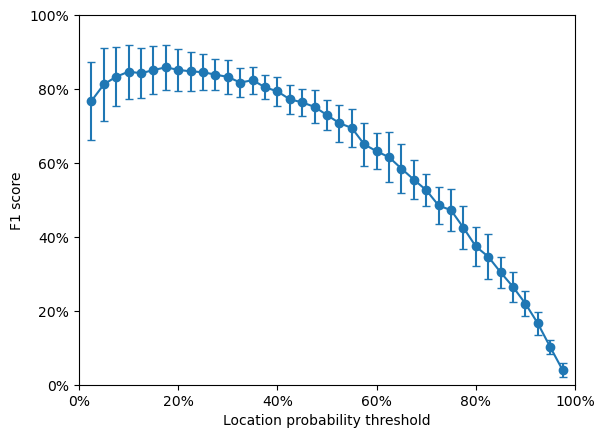

In [6]:
import matplotlib.pyplot as plt
YTICKS = range(0, 101, 20)
XTICKS = YTICKS

plt.errorbar(threshes, f1_means, yerr=f1_stds, fmt='o-', capsize=3)
plt.xlabel('Location probability threshold')
plt.ylabel('F1 score')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.yticks(YTICKS, [str(x)+"%" for x in YTICKS])
plt.xticks(XTICKS, [str(x)+"%" for x in XTICKS])

plt.show()

# SAVE_NAME = "f1_score_vs_probability_thresh"
# import pickle
# plt.savefig(f"/data/MEAprojects/RT-Sort/figures/230119_presentation/{SAVE_NAME}.png", format="png")
# with open(f'/data/MEAprojects/RT-Sort/figures/230119_presentation/{SAVE_NAME}.pickle', "wb") as file:
#     pickle.dump(plt.gcf(), file)